In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score

## Functionspace

In [2]:

# FrankeFunction, from lecture notes
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)

    return term1 + term2 + term3 + term4 


# Defining the R2 function, from lecture notes
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)


# Defining the Mean square error, from lecture notes
def MSE(y,ytilde):
    n = len(y)
    return 1/n * np.sum(np.abs(y-ytilde)**2)



# Creating the design matrix, from lecture notes
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)

    return X


# making the OCS regression
def OLSmethod(X,z):
    return np.linalg.pinv(X.T @ X) @ X.T @ z



#Ridgeregression
def ridgeregg(X,y, lmb = 0.0001):
    XtX = X.T @ X
    p =np.shape(XtX)[0]
    return np.linalg.pinv(XtX +  lmb * np.identity(p)) @ X.T @ y

#Lassoregression using sklern
#def lassoregg(X,y,lmb):
    


def surfaceplot(x,y,z):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

    
def printQ(xdata,xmodel):
    print("--------------------------------------------------------")
    print(f"MSE = |{MSE(xdata,xmodel)}|, R2 = |{r2_score(xdata,xmodel)}|")
    print("--------------------------------------------------------\n")
    
# calculating the MSE, bias and variance using the bootstrap method
def BootstrapOLS(X_train,X_test,z_train,z_test,numberOfStraps):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
    bias = np.zeros(numberOfStraps)
    variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        bootbetaOLS = OLSmethod(bootX,bootz)
        # Making out model and adding it to a list
        ztilde = X_test @ bootbetaOLS
        zpred = X_train @ bootbetaOLS
        MSEdeglisttest[i] =MSE(z_test,ztilde)
        MSEdeglisttrain[i]= MSE(z_train,zpred)
        bias[i],variance[i] = biassVariance(z_test,zpred)
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain), np.mean(bias), np.mean(variance)


def BootstrapRidge(X_train,X_test,z_train,z_test,lam,numberOfStraps):
    MSEdeglisttest = np.zeros(numberOfStraps)
    MSEdeglisttrain = np.zeros(numberOfStraps)
    bias = np.zeros(numberOfStraps)
    variance = np.zeros(numberOfStraps)
    for i in range(numberOfStraps):
        bootX,bootz = resample(X_train,z_train.reshape(-1,1))
        bootbetaRidge = ridgeregg(bootX,bootz,lam)
        # Making out model and adding it to a list
        ztilde = X_test @ bootbetaRidge
        zpred = X_train @ bootbetaRidge
        MSEdeglisttest[i] =MSE(z_test,ztilde)
        MSEdeglisttrain[i]= MSE(z_train,zpred)
        bias[i],variance[i] = biassVariance(z_test,zpred)
    return np.mean(MSEdeglisttest), np.mean(MSEdeglisttrain), np.mean(bias), np.mean(variance)

def plotMSEcomplexity(x,y,z,n):
    MSElisttest = []
    MSElisttrain = []
    biasList =[]
    varianceList =[] 
    n = n+1
    complexity = np.arange(n)
    print(f"The polynomial range is [{complexity[0]},{complexity[-1]}] ")
    
    # Running over the degrees of polynomails
    for degree in complexity:
        # Creating the designmatrix and splitting into train and test
        X = create_X(x,y,degree)
        X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1,1), test_size=0.2)
        
        numberOfStraps = 100
        MSE_train, MSE_test,bias,variance = BootstrapOLS(X_train,X_test,z_train,z_test,numberOfStraps)
        
        
        # Appending the mean to the MSE list when the loop has run for its specific degree
        MSElisttest.append(MSE_train)
        MSElisttrain.append(MSE_test)
        biasList.append(bias)
        varianceList.append(variance)
        
    plt.title('ERROR')
    plt.plot(complexity,MSElisttest,"r", label = "test")
    plt.plot(complexity,MSElisttrain,"k", label = "train")
    plt.xlabel("Polynomial degree")
    plt.grid()
    plt.ylabel("MSE")
    plt.title("Figure of the MSE as a function of the complexity of the model")
    plt.legend()
    plt.show()
    
    plt.title('Bias variance')
    plt.plot(complexity,biasList,"r", label = "bias",ls='',marker='o')
    plt.plot(complexity,varianceList,"k", label = "variance",ls='',marker='o')
    plt.xlabel("Polynomial degree")
    plt.grid()
    plt.ylabel("MSE")
    plt.title("Figure of the MSE as a function of the complexity of the model")
    plt.legend()
    plt.show()
    
    
def confidense(y,X): #returns the 1 sigma confidence interval
    #conf = np.zeros(len(beta))
    betavar = np.var(y)
    XtX = np.linalg.pinv(X.T@X)
    conf = betavar * np.diag(XtX)
    return conf

def biassVariance(y,y_pred): 
    mean_pred = np.mean(y_pred)
    bias = np.mean((y - mean_pred)**2)
    variance = np.mean((y_pred - mean_pred)**2)
    return bias, variance


def k_foldOLS(Data, k,X): 
    "Splitting the data"
    k_split = KFold(n_splits = k)
    "CV to calculate MSE"
    k_scores= np.zeros(k)
    i = 0
    for k_train_index, k_test_index in k_split.split(X):
        #print(k_train_index)
        k_xtrain = X[k_train_index]
        k_ytrain = Data[k_train_index]
        
       # print(k_xtrain)
        
        k_xtest = X[k_test_index]
        k_ytest = Data[k_test_index]

        #k_Xtrain = poly.fit_transform(k_xtrain[:, np.newaxis])
        "Finding betaOLS for each k"
        beta_k_OLS = OLSmethod(k_xtrain, k_ytrain)

        #k_Xtest = poly.fit_transform(k_xtest[:, np.newaxis])
        model_predict = k_xtest @ beta_k_OLS

        k_scores[i] = MSE(k_ytest, model_predict)

        i += 1
  #  print(k_scores)
    MSE_kfold = np.mean(k_scores)
   # print('MSE for k-fold OLS')
   # print(MSE_kfold)
    return MSE_kfold

def k_foldRidge(Data, k,X,lam =1): 
    "Splitting the data"
    k_split = KFold(n_splits = k)
    "CV to calculate MSE"
    k_scores= np.zeros(k)
    i = 0
    for k_train_index, k_test_index in k_split.split(X):
        #print(k_train_index)
        k_xtrain = X[k_train_index]
        k_ytrain = Data[k_train_index]
        
       # print(k_xtrain)
        
        k_xtest = X[k_test_index]
        k_ytest = Data[k_test_index]

        #k_Xtrain = poly.fit_transform(k_xtrain[:, np.newaxis])
        "Finding betaOLS for each k"
        beta_k_Ridge = ridgeregg(k_xtrain, k_ytrain)

        #k_Xtest = poly.fit_transform(k_xtest[:, np.newaxis])
        model_predict = k_xtest @ beta_k_Ridge

        k_scores[i] = MSE(k_ytest, model_predict)

        i += 1
    MSE_kfold = np.mean(k_scores)
    return MSE_kfold



## Task 1

In [3]:
npoints = 200


# Make data.
x = np.sort(np.random.uniform(0, 1, npoints)) 
y = np.sort(np.random.uniform(0, 1, npoints)) 


#x, y = np.meshgrid(x,y)


z = FrankeFunction(x, y) 
z = z #+ .1 * np.random.randn(npoints)

#surfaceplot(x,y,z)


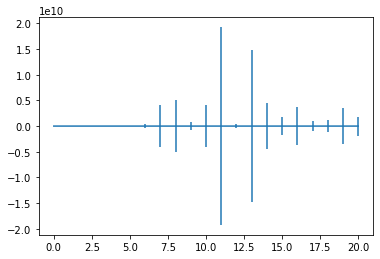

The variance is 190197852.83317077
13791.223761261028
For the training data we get a MSE of
--------------------------------------------------------
MSE = |0.001149913022995866|, R2 = |0.9931509214540469|
--------------------------------------------------------

For the test data we get a MSE of
--------------------------------------------------------
MSE = |0.0014005833776969201|, R2 = |0.9917115557530373|
--------------------------------------------------------

MSE_kfold:  0.007052813558854204
bootTest:  0.001826864485257516


In [4]:
n = 5


#x = np.sort(np.random.uniform(0.0 , 1.0 , npoints)) 
#y = np.sort(np.random.uniform(0.0 , 1.0 , npoints))


#x, y = np.meshgrid(x,y)


X = create_X(x,y,n)




X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1,1), test_size=0.2)


betaOLS = OLSmethod(X_train , z_train)


#finding the variance of beta
p = int((n+1)*(n+2)/2)


betaOLS_var = confidense(z_train,X_train)

plt.errorbar(range(p), betaOLS, yerr= betaOLS_var)
plt.show()



print(f"The variance is {np.var(betaOLS)}")
print(np.std(betaOLS))



zpred = X_train@betaOLS
print("For the training data we get a MSE of")
printQ(z_train,zpred)


print("For the test data we get a MSE of")
ztilde = X_test@betaOLS
printQ(z_test,ztilde)



MSElist = []
R2list = []
for i in range(28):
    bootX,bootz = resample(X_train,z_train.reshape(-1,1))


    bootbetaOLS = OLSmethod(bootX,bootz)
    
    ypred = bootX @ bootbetaOLS
    MSElist.append(MSE(z_train,ypred))
    R2list.append(R2(bootz,ypred))
    

#X_scale = np.ones_like(X)
#scaler = StandardScaler()
#X_scale[1:,:] = scaler.fit_transform(X[1:,:])
#z_scaled = scaler.fit_transform(z.reshape(-1,1))




#X_strain, X_stest, z_strain, z_stest = train_test_split(X_scale, z_scaled.reshape(-1,1) , test_size = 0.2 )

#print(np.mean(MSElist))
#print(np.mean(R2list))


print('MSE_kfold: ',k_foldOLS(z, 20,X))
boot_train_error, boot_test_error, variance,bias =BootstrapOLS(X_train,X_test,z_train,z_test,100)
print('bootTest: ', boot_test_error)


## For the scaled data

In [5]:
scaler = StandardScaler()

X_scale = scaler.fit_transform(X)
z_scaled = scaler.fit_transform(z.reshape(-1,1))




X_strain, X_stest, z_strain, z_stest = train_test_split(X_scale, z_scaled.reshape(-1,1) , test_size = 0.2 )

betascaledOCS = np.linalg.pinv(X_strain.T@X_strain)@ X_strain.T @ z_strain
print(f"The variance of the scaled coefficients is {np.var(betascaledOCS)}\n")

zpreds = X_strain@betascaledOCS



print(f"Under we print the different values for MSE and R2")



print("For the scaled training data we get a MSE and R2 of:")
printQ(z_strain,zpreds)


print("For the scaled test data we get a MSE and R2 of: ")
ztilde = X_stest @ betascaledOCS

printQ(z_stest,ztilde)


The variance of the scaled coefficients is 69030480.60052249

Under we print the different values for MSE and R2
For the scaled training data we get a MSE and R2 of:
--------------------------------------------------------
MSE = |0.007257150577811278|, R2 = |0.9924378559366976|
--------------------------------------------------------

For the scaled test data we get a MSE and R2 of: 
--------------------------------------------------------
MSE = |0.006110674029255228|, R2 = |0.9943472838056155|
--------------------------------------------------------



## Task 2

The polynomial range is [0,10] 


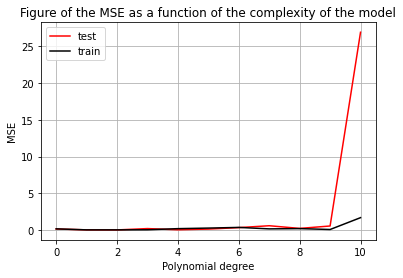

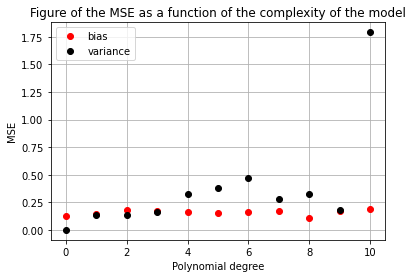

In [6]:
npoints = 50


# Make data.
x = np.sort(np.random.uniform(0, 1, npoints)) 
y = np.sort(np.random.uniform(0, 1, npoints)) 


#x, y = np.meshgrid(x,y)


z = FrankeFunction(x, y) 
z = z #+ 0.1 * np.random.randn(npoints)


n = 10

plotMSEcomplexity(x,y,z,n)



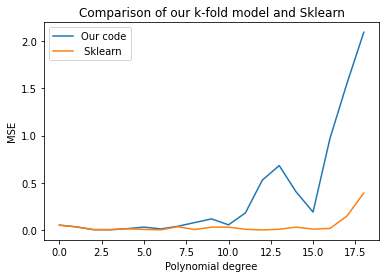

In [70]:
#K_fold

scaler = StandardScaler()


npoints = 200


# Make data.
x = np.sort(np.random.uniform(0, 1, npoints)) 
y = np.sort(np.random.uniform(0, 1, npoints)) 


#x, y = np.meshgrid(x,y)


z = FrankeFunction(x, y) 
z = z #+ 0.1 * np.random.randn(npoints)





# Setting the polynomial degree
n = 20
# Setting the k value for the folding
k = 10


# Creating arrays to store the MSE
estimated_mse_sklearn = np.zeros(n-1)
M_list = np.zeros(n-1)

kfoldc = KFold(n_splits = k)

for j in range(1,n):
    X = create_X(x,y,j)
    #X_scale = scaler.fit_transform(X)
    #z_scale = scaler.fit_transform(z.reshape(-1,1))
    M_list[j-1] = k_foldOLS(z,k,X)
    

    
    # The Sklearn model
    ols1 = LinearRegression()
    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_folds = cross_val_score(ols1, X, z, scoring='neg_mean_squared_error', cv=kfoldc)
    estimated_mse_sklearn[j-1] = np.mean(-estimated_mse_folds)
    
   
    
    
plt.plot(M_list, label = "Our code")
plt.plot(estimated_mse_sklearn, label = " Sklearn ")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.legend()
plt.title("Comparison of our k-fold model and Sklearn")
plt.show()




    

## Plot and compare the slightly different ways to perform cross-validation









## Ridge

In [ ]:
lam = np.logspace(-4,4)
lam_n = np.size(lam)
degrees = 27

Bootstrapp_train_errors = np.zeros((lam_n,degrees))
Bootstrapp_test_errors = np.zeros((lam_n,degrees))
bias_List =  np.zeros((lam_n,degrees))
variance_List = np.zeros((lam_n,degrees))
i,j = 0,0

for alpha in lam:
    for degree in range(degrees):
        X = create_X(x,y,degree)
        X_strain, X_stest, z_strain, z_stest = train_test_split(X_scale, z_scaled.reshape(-1,1) , test_size = 0.2 )
        bootstrap_train, bootstrap_test,bias,variance = BootstrapRidge(X_train,X_test,z_train,z_test,alpha,30)
        Bootstrapp_train_errors[i,j] =  bootstrap_train
        Bootstrapp_test_errors[i,j] = bootstrap_test
        bias_List[i,j] = bias
        variance_List[i,j] = variance
        j +=1
    i +=1
    j=0


In [ ]:
plt.semilogx(lam,Bootstrapp_train_errors[:,4],label='train')
plt.semilogx(lam,Bootstrapp_test_errors[:,4],label='test')
plt.legend()
plt.show()

plt.semilogx(lam,variance_List[:,10],label='var',marker='o',ls='')
plt.semilogx(lam,bias_List[:,10],label='bias',marker='o',ls='')
plt.legend()
plt.show()